<h1 style="color:#7b1e1e; text-align:center; font-family: Arial, sans-serif;">
    Projet personnel de scoring de crédit 
</h1>
<p style="text-align:center; font-style: italic; color:#5a5a5a;">
    Analyse du risque de défaut et création d'un modèle prédictif à partir du jeu de données credit_risk_dataset sur Kaggle.
</p>

---

<h2 style="color:#8c2f2f;">
    Introduction
</h2>

Dans le secteur financier, évaluer avec précision le risque de défaut est primordial pour la rentabilité et la stabilité des établissements de crédit. Ce projet vise à développer un modèle de scoring performant en utilisant des techniques de Machine Learning. À partir d'un jeu de données (https://www.kaggle.com/datasets/laotse/credit-risk-dataset) contenant des informations personnelles et financières sur des emprunteurs lambda, nous allons explorer les données, préparer les variables pertinentes, puis entraîner et comparer plusieurs modèles de classification (régression logistique, forêt aléatoire et XGBoost). L'objectif final est de sélectionner le modèle le plus apte à prédire si un nouveau client est susceptible de faire défaut sur son prêt, afin de fournir un outil d'aide à la décision fiable et automatisé.

Ce notebook est structuré comme suit :
<ol>
    <li><strong>Préparation et exploration des données :</strong> Importation, nettoyage (doublons, valeurs manquantes, valeurs aberrantes) et première analyse descriptive.</li>
    <li><strong>Analyse exploratoire :</strong> Visualisations pour comprendre les relations entre les variables et identifier les features les plus pertinentes.</li>
    <li><strong>Modélisation et évaluation :</strong> Préparation des données pour l'entraînement, optimisation et comparaison de trois modèles (régression logistique, forêt aléatoire, XGBoost).</li>
    <li><strong>Conclusion et perspectives :</strong> Synthèse des résultats et discussion des prochaines étapes possibles.</li>
</ol>

<h2 style="color:#8c2f2f;">
    I- Préparation et exploration des données
</h2>

<h3 style="color:#9e3b3b;">
    A. Import des librairies et du jeu de données
</h3>

In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    FunctionTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    f1_score,
    accuracy_score,
    ConfusionMatrixDisplay
)
from dython.nominal import associations
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
import shap
shap.initjs()

In [183]:
# Configuration
DATA_PATH = "../data/credit_risk_dataset.csv"
TEST_SIZE = 0.10       
VAL_SIZE = 0.10        
RANDOM_STATE = 42

In [184]:
credit = pd.read_csv(DATA_PATH)

<h3 style="color:#9e3b3b;">
    B. Exploration des données
</h3>

In [185]:
credit.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


- **person_age** : Âge de l’individu qui fait la demande de prêt.  
- **person_income** : Revenu annuel de l’individu.  
- **person_home_ownership** : Type de propriété du logement de l’individu.  
  - **rent** : L’individu loue actuellement un logement.  
  - **mortgage** : L’individu a une hypothèque sur le logement qu’il possède.  
  - **own** : L’individu possède son logement sans crédit.  
  - **other** : Autres catégories de propriété du logement pouvant être spécifiques au jeu de données.  
- **person_emp_length** : Ancienneté professionnelle de l’individu en années.  
- **loan_intent** : Motif de la demande de prêt.  
- **loan_grade** : La note attribuée au prêt en fonction de la solvabilité de l’emprunteur.  
  - **A** : L’emprunteur a une grande solvabilité, indiquant un faible risque.  
  - **B** : L’emprunteur présente un risque relativement faible, mais inférieur à la note A.  
  - **C** : La solvabilité de l’emprunteur est moyenne.  
  - **D** : L’emprunteur est considéré comme présentant un risque plus élevé que les notes précédentes.  
  - **E** : La solvabilité de l’emprunteur est faible, indiquant un risque élevé.  
  - **F** : L’emprunteur présente un risque de crédit significatif.  
  - **G** : La solvabilité de l’emprunteur est la plus faible, signifiant le risque le plus élevé.  
- **loan_amnt** : Montant du prêt demandé par l’individu.  
- **loan_int_rate** : Taux d’intérêt associé au prêt.  
- **loan_status** : Statut du prêt, où 0 indique aucun défaut de paiement et 1 indique un défaut.  
  - **0** : Aucun défaut – L’emprunteur a remboursé le prêt comme convenu, sans défaut.  
  - **1** : Défaut – L’emprunteur n’a pas respecté les conditions de remboursement et a fait défaut sur le prêt.  
- **loan_percent_income** : Pourcentage du revenu représenté par le montant du prêt.  
- **cb_person_default_on_file** : Antécédent de défaut de paiement de l’individu selon les registres du bureau de crédit.  
  - **Y** : L’individu a des antécédents de défauts de paiement.  
  - **N** : L’individu n’a aucun antécédent de défaut de paiement.  
- **cb_preson_cred_hist_length** : Durée de l’historique de crédit de l’individu.

In [186]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


<h3 style="color:#9e3b3b;">
    C. Nettoyage et prétraitement
</h3>

#### - Statistiques descriptives des variables numériques

In [187]:
credit.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


#### - Statistiques descriptives des variables qualitatives

In [188]:
credit.describe(include='O')

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,32581,32581,32581,32581
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,16446,6453,10777,26836


<h4 style="color:#b55e5e;">
    1. Vérification des doublons
</h4>

In [189]:
credit.duplicated().sum()

165

In [190]:
credit = credit.drop_duplicates() 

<h4 style="color:#b55e5e;">
    2. Gestion des valeurs manquantes
</h4>

In [191]:
credit.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [192]:
credit[['person_emp_length', 'loan_int_rate']].isnull().mean() * 100 # Pourcentage de valeurs manquantes
# dans les colonnes person_emp_length et loan_int_rate

person_emp_length    2.736303
loan_int_rate        9.547754
dtype: float64

Nous avons des valeurs manquantes pour les variables `person_emp_length` et `loan_int_rate`. Nous allons pour chacune d'elles étudier leur distribution pour pouvoir décider de ce que nous allons en faire.

#### - Pour la variable person_emp_length

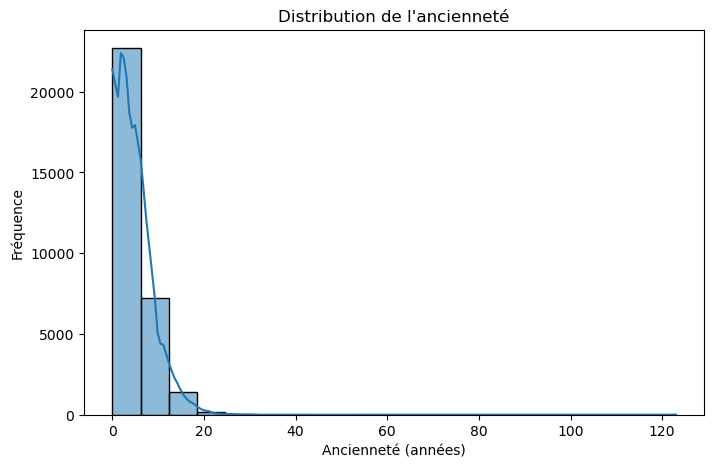

In [193]:
plt.figure(figsize=(8,5))
sns.histplot(credit['person_emp_length'], bins=20, kde=True)  
plt.title("Distribution de l'ancienneté")
plt.xlabel("Ancienneté (années)")
plt.ylabel("Fréquence")
plt.show()

La distribution de l'ancienneté est asymétrique. La grande majorité des individus a peu d'années d'expérience, et une minorité seulement a une longue carrière (plus de 30 ans). Ainsi, nous préférons remplacer les valeurs manquantes de cette variable par la médiane plutôt que par la moyenne. En effet, les valeurs élevées peuvent tirer la moyenne vers le haut, la rendant moins représentative du centre de la distribution. La médiane, elle, n'est pas affectée par ces valeurs extrêmes. Elle représente donc mieux l'ancienneté "typique" d'une personne dans le jeu de données.

In [194]:
median_emp_length = credit['person_emp_length'].median()
credit.loc[:, 'person_emp_length'] = credit['person_emp_length'].fillna(median_emp_length) 

#### - Pour la variable loan_int_rate

La variable `loan_int_rate` a également près de 10% de valeurs manquantes. Une première idée serait de les imputer de manière intelligente. Par exemple, comme le taux d'intérêt est fortement corrélé à la note du prêt (`loan_grade`), on pourrait remplacer les valeurs manquantes par la médiane des taux pour chaque `loan_grade`. Le coefficient de corrélation de 0.93 entre ces deux variables confirme que cette approche serait plus précise qu'une simple médiane globale.
Cependant, cette démarche soulève une question fondamentale : les variables `loan_int_rate` et `loan_grade` sont-elles des informations disponibles avant la décision de crédit ? Très probablement non. Elles sont le résultat de cette évaluation.
Les utiliser pour prédire le défaut de paiement créerait une fuite de données (data leakage) : le modèle "tricherait" en utilisant une information qui contient déjà la réponse. Pour construire un modèle prédictif réaliste et applicable à de nouveaux clients (pour qui nous n'avons ni note ni taux), il est impératif de supprimer ces variables.

In [195]:
grade_order = sorted(credit['loan_grade'].unique())
# Pour calculer une corrélation, il faut transformer 'loan_grade' en numérique
# Nous créons une nouvelle colonne pour ne pas modifier l'originale
# Nous respections l'ordre : 'A' est le meilleur (valeur la plus basse), 'G' le pire (valeur la plus haute)
grade_mapping = {grade: i for i, grade in enumerate(grade_order)}
credit['loan_grade_numeric'] = credit['loan_grade'].map(grade_mapping)

# Calcul de la matrice de corrélation sur les deux colonnes d'intérêt
correlation_matrix = credit[['loan_grade_numeric', 'loan_int_rate']].corr()
print("Matrice de corrélation :")
print(correlation_matrix)

Matrice de corrélation :
                    loan_grade_numeric  loan_int_rate
loan_grade_numeric            1.000000       0.933721
loan_int_rate                 0.933721       1.000000


In [196]:
credit = credit.drop(columns=["loan_grade", "loan_int_rate"])

In [197]:
credit.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_amnt                     0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_grade_numeric            0
dtype: int64

In [198]:
credit = credit.drop("loan_grade_numeric", axis=1) # Suppression de loan_grade_numeric qui est
# une simple copie numérique de la variable loan_grade 

<h4 style="color:#b55e5e;">
    3. Gestion des valeurs aberrantes
</h4>

In [199]:
col_num = credit.select_dtypes(include=['int64', 'float64']).columns.tolist()

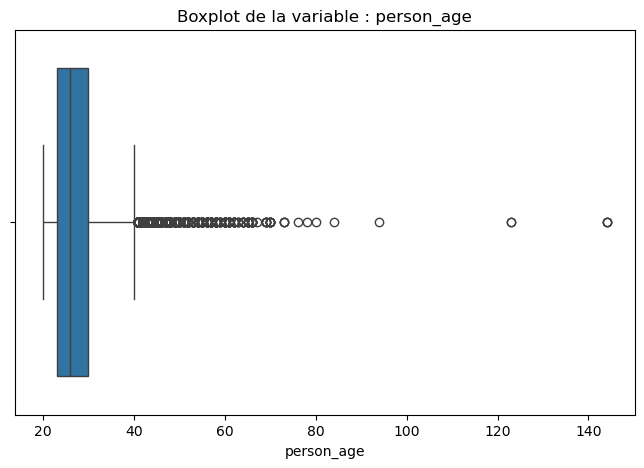

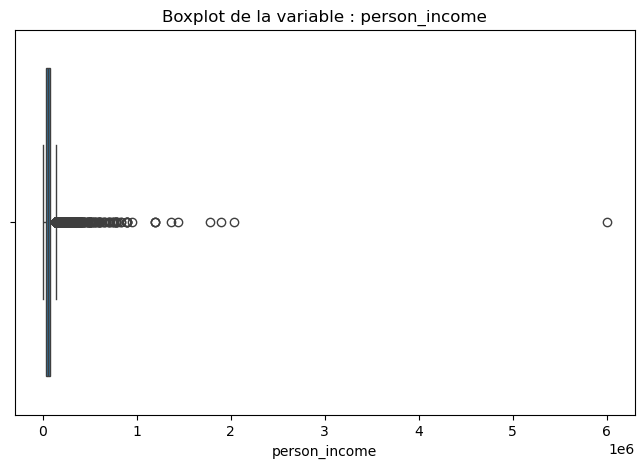

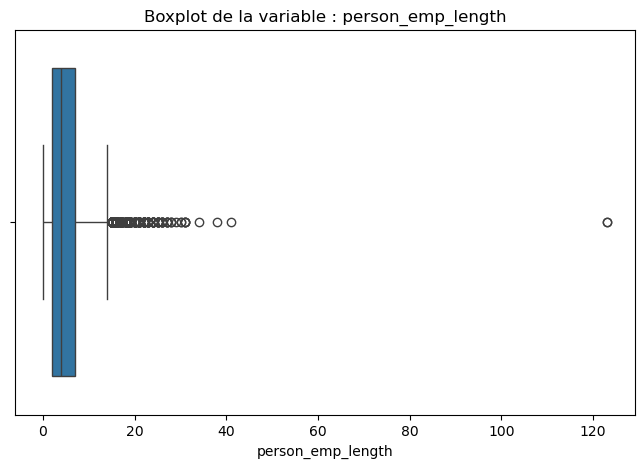

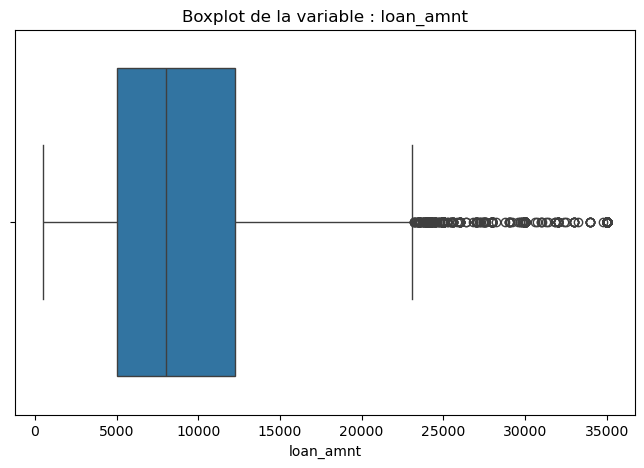

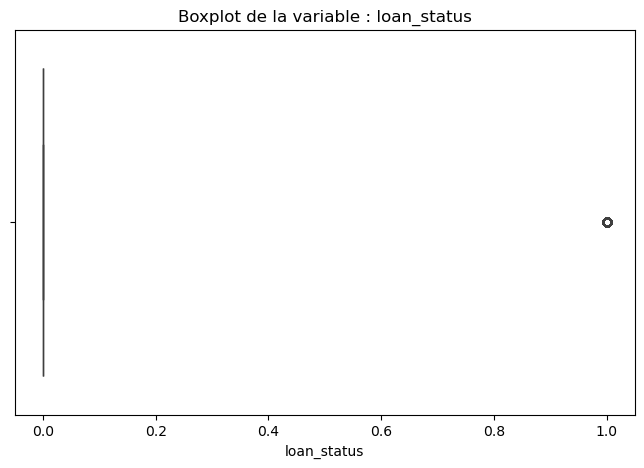

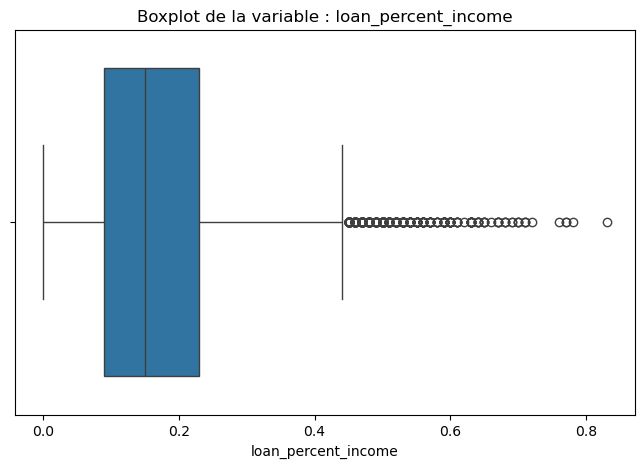

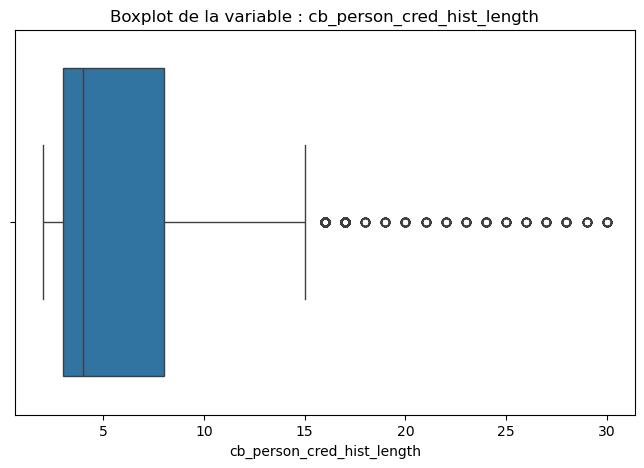

In [200]:
for col in col_num :
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=credit[col])
    plt.title(f'Boxplot de la variable : {col}')
    plt.xlabel(col)
    plt.show()

Les boîtes à moustaches nous signalent des valeurs aberrantes qui sont très probablement des erreurs de saisie :  

- **person_age** : Certains individus ont plus de 100 ans. Nous supprimerons ces lignes.  
- **person_emp_length** : Une ancienneté supérieure à 100 ans est impossible. Nous traiterons également ces cas.  
- **person_income** : Nous observons des revenus annuels très élevés (plus d'un million de dollars). Contrairement à l'âge, ces valeurs pourraient être légitimes.  
  Les supprimer pourrait biaiser notre analyse. Nous allons donc les conserver pour l'instant, mais nous garderons à l'esprit qu'une transformation logarithmique pourrait être bénéfique pour stabiliser la variance et réduire l'influence de ces outliers sur la régression logistique.

In [201]:
(credit['person_age'] > 100).sum()

5

In [202]:
credit = credit[credit['person_age'] <= 100]

In [203]:
(credit['person_emp_length'] > 100).sum()

2

In [204]:
credit = credit[credit['person_emp_length'] <= 100]

In [205]:
credit.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,1000,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,5500,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,35000,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,35000,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,2500,1,0.25,N,2


<h2 style="color:#8c2f2f;">
    II- Analyse exploratoire des données
</h2>

<h3 style="color:#9e3b3b;">
    A. Analyse de la variable cible 
</h3>

In [206]:
X = credit.drop(columns='loan_status')
y = credit['loan_status']

In [207]:
X.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,1000,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,5500,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,35000,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,35000,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,2500,0.25,N,2


In [208]:
y.head()

1    0
2    1
3    1
4    1
5    1
Name: loan_status, dtype: int64

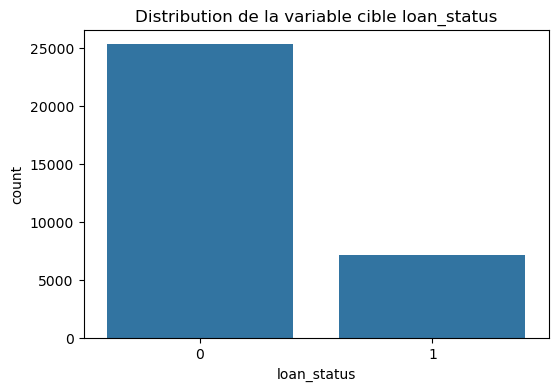

In [209]:
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Distribution de la variable cible loan_status")
plt.show()

Nous avons des données déséquilibrées. Le nombre de clients qui font défaut (`loan_status` = 1) est bien plus faible que le nombre de ceux qui ne font pas défaut (`loan_status` = 0). Si nous ne prenons pas en compte ce déséquilibre, notre modèle risquerait de toujours prédire le non-défaut du client, ce qui serait embêtant pour un établissement bancaire. Pour éviter cela, nous pouvons essayer de rééchantilloner les données.

<h3 style="color:#9e3b3b;">
    B. Distributions et répartitions des variables  
</h3>

In [210]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32409 entries, 1 to 32580
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32409 non-null  int64  
 1   person_income               32409 non-null  int64  
 2   person_home_ownership       32409 non-null  object 
 3   person_emp_length           32409 non-null  float64
 4   loan_intent                 32409 non-null  object 
 5   loan_amnt                   32409 non-null  int64  
 6   loan_percent_income         32409 non-null  float64
 7   cb_person_default_on_file   32409 non-null  object 
 8   cb_person_cred_hist_length  32409 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 2.5+ MB


In [211]:
var_nominal = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']
var_num = ['person_age','person_income','person_emp_length','loan_amnt','loan_percent_income','cb_person_cred_hist_length']

<h4 style="color:#b55e5e;">
    1. Distribution des variables numériques 
</h4>

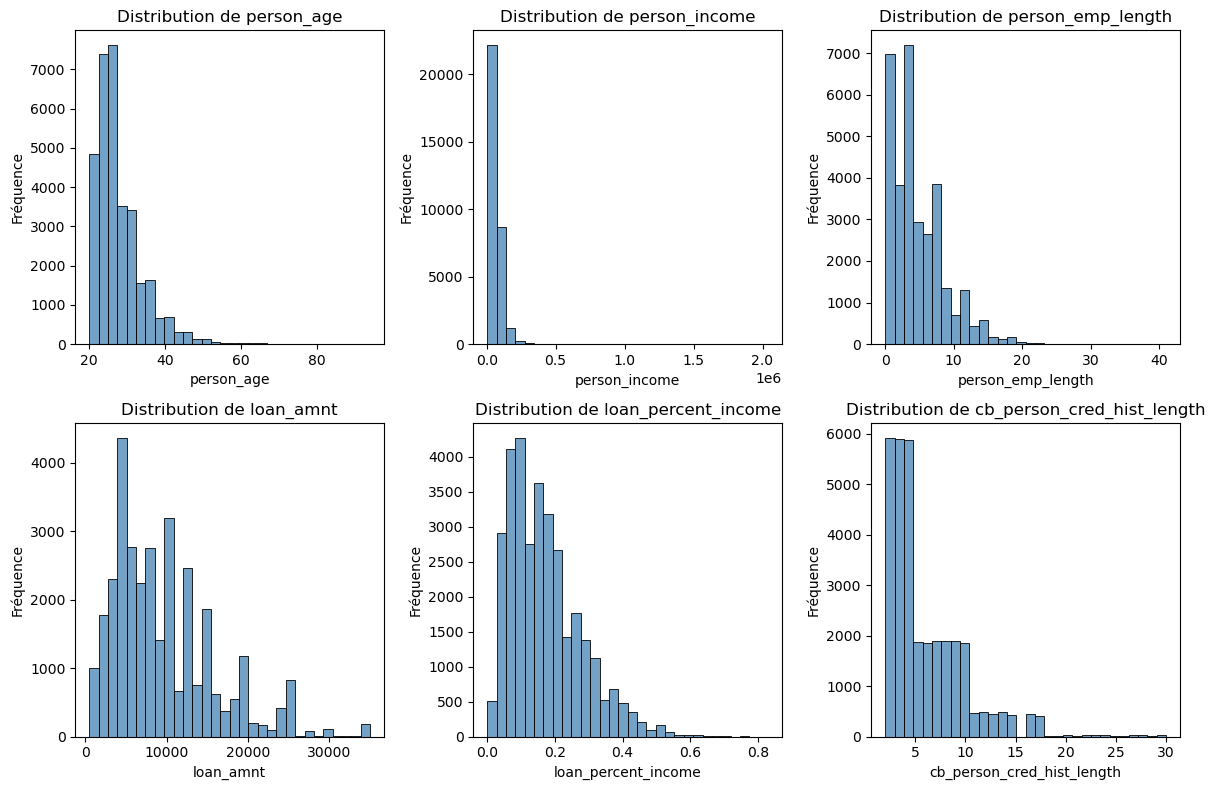

In [212]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(var_num, 1):
    plt.subplot(2, 3, i)  
    sns.histplot(data=X, x=col, bins=30, color='steelblue', kde=False)
    plt.title(f'Distribution de {col}')
    plt.xlabel(col)
    plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

La plupart des variables numériques présentent une distribution asymétrique à droite. Une transformation logarithmique pourrait être appliquée pour mieux normaliser les données et faciliter l’apprentissage des modèles.

<h4 style="color:#b55e5e;">
    2. Répartition des variables catégorielles 
</h4>

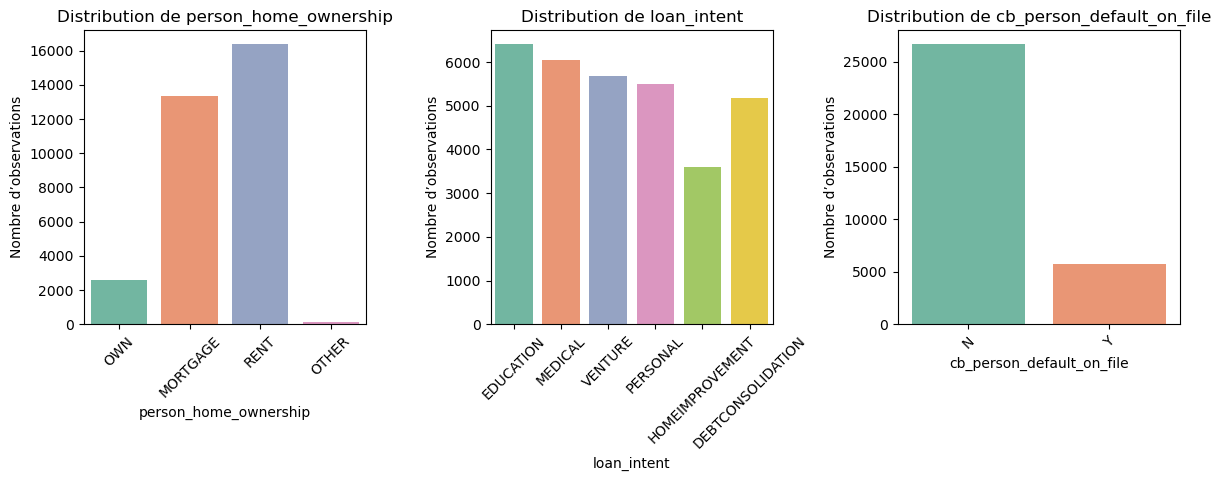

In [213]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(var_nominal, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=X, x=col, hue=col, palette='Set2', legend=False)
    plt.title(f'Distribution de {col}')
    plt.xlabel(col)
    plt.ylabel('Nombre d’observations')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

La modalité “OTHER” est marginale au sein de la variable `person_home_ownership`.
Bien qu’un regroupement avec une catégorie proche puisse limiter les effets liés au déséquilibre des classes, aucune modalité suffisamment similaire n’étant disponible, nous avons décidé de la maintenir dans l’analyse.

<h3 style="color:#9e3b3b;">
    C. Relations entre les variables explicatives qualitatives et la variable dépendante  
</h3>

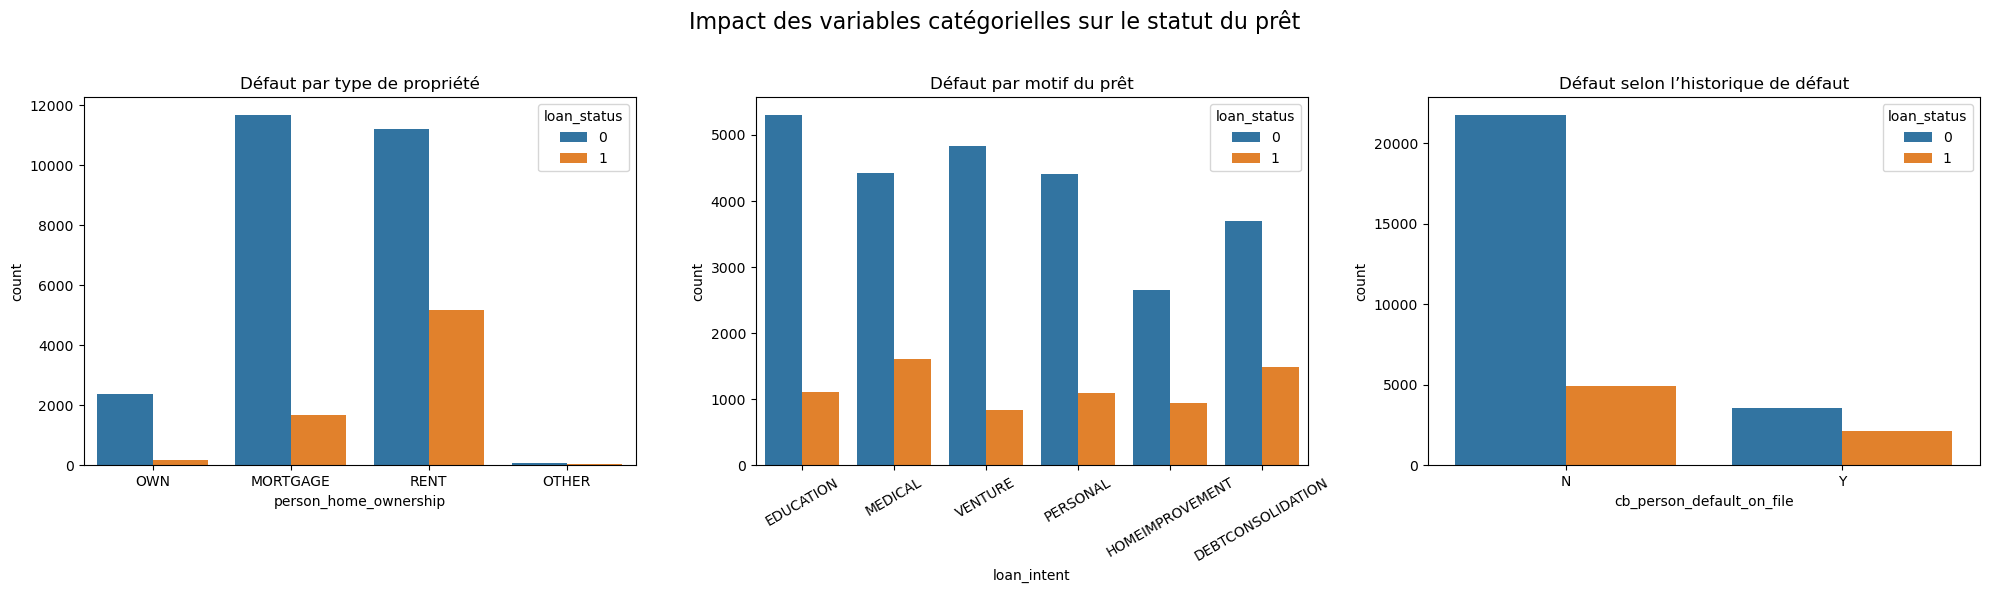

In [214]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle("Impact des variables catégorielles sur le statut du prêt", fontsize=16)

# Type de propriété
sns.countplot(ax=axes[0], data=credit, x="person_home_ownership", hue="loan_status")
axes[0].set_title("Défaut par type de propriété")

# Motif du prêt
sns.countplot(ax=axes[1], data=credit, x="loan_intent", hue="loan_status")
axes[1].tick_params(axis="x", rotation=30)
axes[1].set_title("Défaut par motif du prêt")

# Historique de défaut
sns.countplot(ax=axes[2], data=credit, x="cb_person_default_on_file", hue="loan_status")
axes[2].set_title("Défaut selon l’historique de défaut")  

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Nous observons clairement que les personnes ayant déjà eu un défaut par le passé (`cb_person_default_on_file` = Y) ont un taux de défaut bien plus élevé que celles qui n'en ont jamais eu.

<h3 style="color:#9e3b3b;">
    D. Relations entre les variables explicatives numériques et la variable dépendante
</h3>

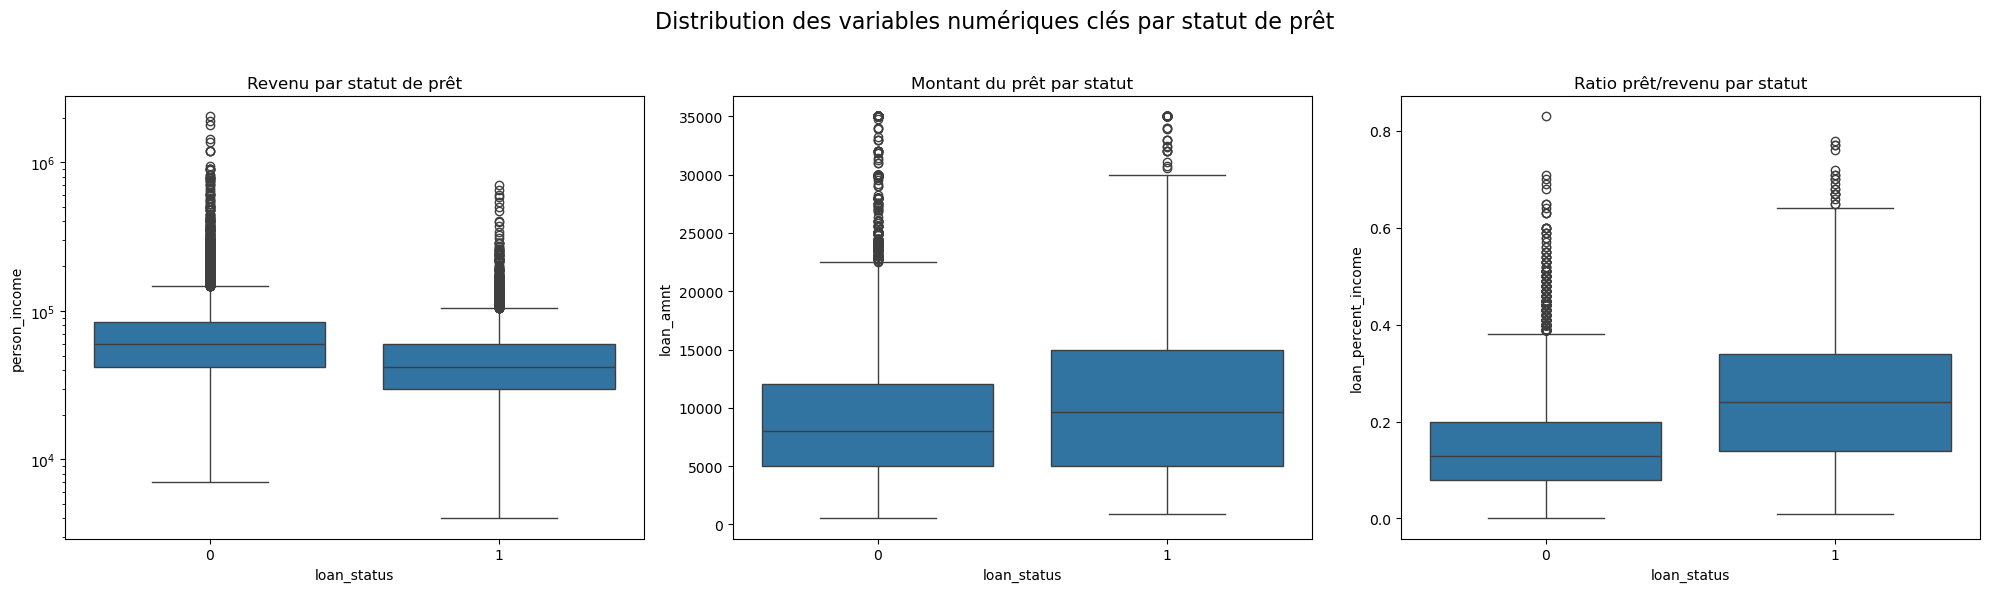

In [215]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle("Distribution des variables numériques clés par statut de prêt", fontsize=16)

sns.boxplot(ax=axes[0], data=credit, x='loan_status', y='person_income')
axes[0].set_title("Revenu par statut de prêt")
axes[0].set_yscale('log') # Echelle log pour mieux visualiser

sns.boxplot(ax=axes[1], data=credit, x='loan_status', y='loan_amnt')
axes[1].set_title("Montant du prêt par statut")

sns.boxplot(ax=axes[2], data=credit, x='loan_status', y='loan_percent_income')
axes[2].set_title("Ratio prêt/revenu par statut")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Nous pouvons observer que les clients en défaut de paiement ont en général un revenu plus faible que ceux qui remboursent leur prêt. De plus, les prêts non remboursés sont souvent d’un montant plus important que les prêts remboursés. Ainsi, les clients non solvables se distinguent par un ratio prêt/revenu plus élevé.

<h3 style="color:#9e3b3b;">
    D. Matrice de corrélation  
</h3>

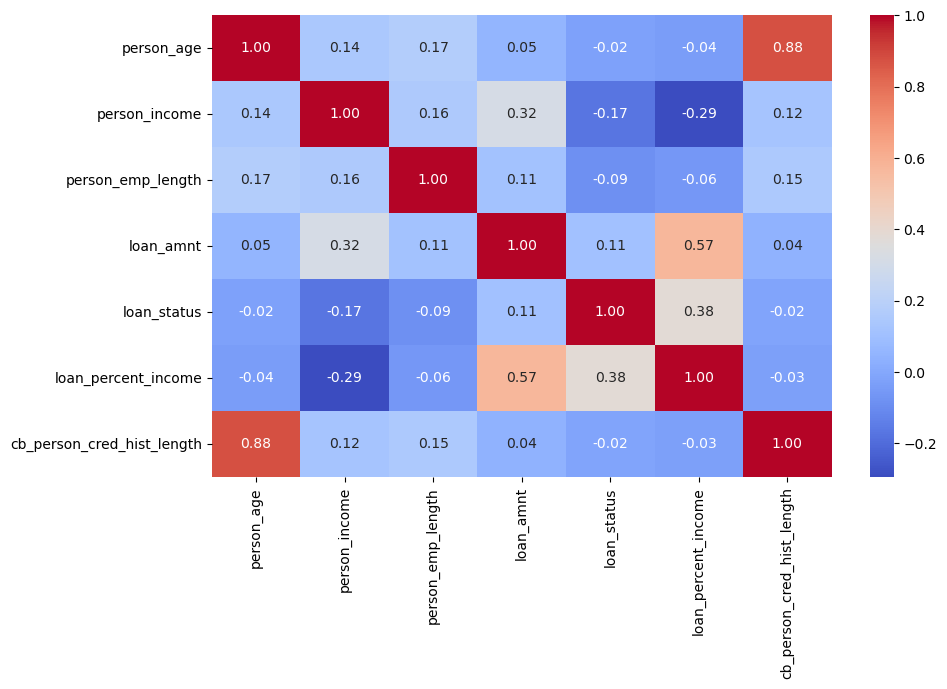

In [216]:
plt.figure(figsize=(10, 6))
sns.heatmap(credit.select_dtypes(include=['number']).corr(), 
            annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

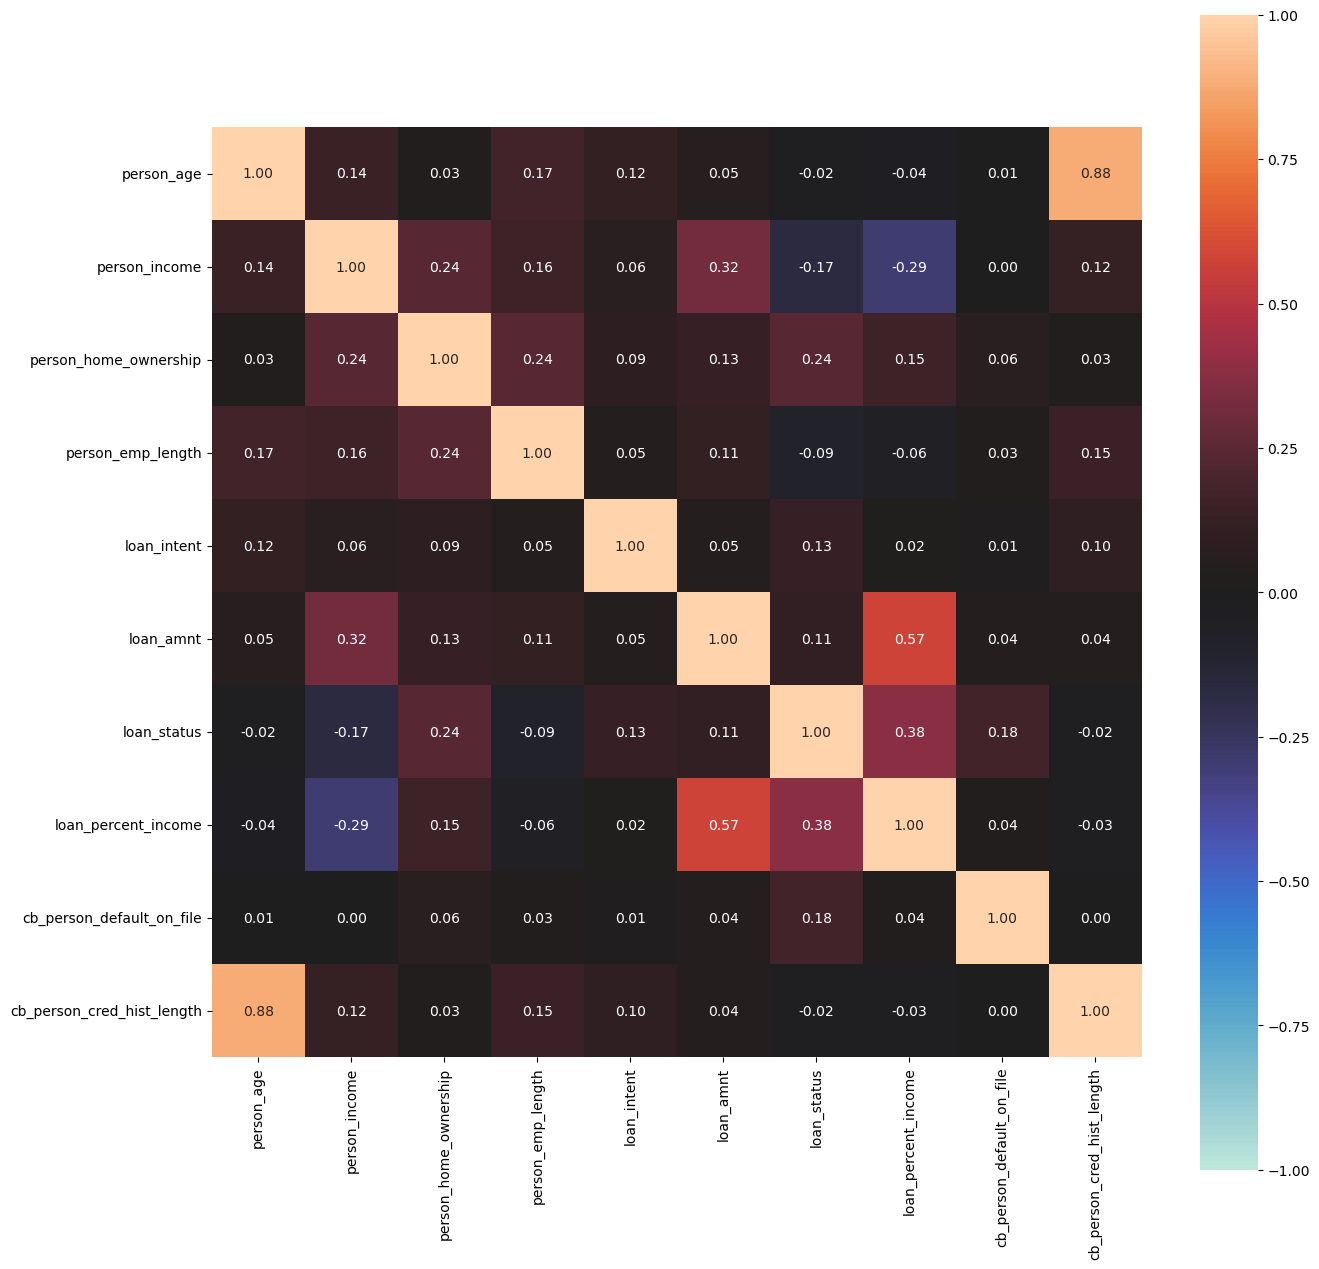

{'corr':                             person_age  person_income  person_home_ownership  person_emp_length  loan_intent  loan_amnt  loan_status  loan_percent_income  cb_person_default_on_file  cb_person_cred_hist_length
 person_age                    1.000000       0.140487               0.034815           0.170606     0.116537   0.051646    -0.021774            -0.041468                   0.006584                    0.878240
 person_income                 0.140487       1.000000               0.237589           0.155094     0.063250   0.316732    -0.169262            -0.294766                   0.002520                    0.122654
 person_home_ownership         0.034815       0.237589               1.000000           0.238740     0.086643   0.132737     0.241730             0.148478                   0.064760                    0.027620
 person_emp_length             0.170606       0.155094               0.238740           1.000000     0.046383   0.111896    -0.085967            -0.0584

In [217]:
associations(credit, nominal_columns='auto', plot=True) #Matrice d'association

Nous observons une forte corrélation positive (0.88) entre les variables `person_age` et `cb_person_cred_hist_length`. Nous allons uniquement garder `person_age` pour la suite afin d'éviter les problèmes de multicolinéarité et de réduire la redondance dans notre modèle.

In [218]:
X = X.drop(columns=["cb_person_cred_hist_length"])

In [219]:
X.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_percent_income,cb_person_default_on_file
1,21,9600,OWN,5.0,EDUCATION,1000,0.10,N
2,25,9600,MORTGAGE,1.0,MEDICAL,5500,0.57,N
3,23,65500,RENT,4.0,MEDICAL,35000,0.53,N
4,24,54400,RENT,8.0,MEDICAL,35000,0.55,Y
5,21,9900,OWN,2.0,VENTURE,2500,0.25,N


<h2 style="color:#8c2f2f;">
    III- Modélisation et évaluation
</h2>

<h3 style="color:#9e3b3b;">
    A. Préparation des données pour le modèle
</h3>

<h4 style="color:#b55e5e;">
    1. Encodage des variables qualitatives et normalisation des variables numériques
</h4>

In [220]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32409 entries, 1 to 32580
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   person_age                 32409 non-null  int64  
 1   person_income              32409 non-null  int64  
 2   person_home_ownership      32409 non-null  object 
 3   person_emp_length          32409 non-null  float64
 4   loan_intent                32409 non-null  object 
 5   loan_amnt                  32409 non-null  int64  
 6   loan_percent_income        32409 non-null  float64
 7   cb_person_default_on_file  32409 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 2.2+ MB


In [221]:
var_nominal = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']
var_num = ['person_age','person_income','person_emp_length','loan_amnt','loan_percent_income']

In [222]:
numeric_pipeline = Pipeline(steps=[
    ('log_transform', FunctionTransformer(np.log1p)), # Transformation logarithmique des variables numériques 
    ('scaler', StandardScaler())
])

In [223]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, var_num), 
        ('nom', OneHotEncoder(drop='first', sparse_output=False), var_nominal)
    ],
    remainder='passthrough'
)

In [224]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=VAL_SIZE / (1 - TEST_SIZE), 
    random_state=RANDOM_STATE, stratify=y_temp
) #Séparation en ensembles d'entrainement, de validation et de test

In [225]:
print(f"Taille du jeu d'entraînement : {X_train.shape}")
print(f"Taille du jeu de validation  : {X_val.shape}")
print(f"Taille du jeu de test        : {X_test.shape}")

Taille du jeu d'entraînement : (25927, 8)
Taille du jeu de validation  : (3241, 8)
Taille du jeu de test        : (3241, 8)


In [226]:
X_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_percent_income,cb_person_default_on_file
2972,22,35000,MORTGAGE,3.0,MEDICAL,3500,0.10,Y
9475,23,76500,RENT,0.0,DEBTCONSOLIDATION,8000,0.10,N
28490,28,59600,RENT,2.0,DEBTCONSOLIDATION,5000,0.08,N
10792,24,41000,RENT,4.0,EDUCATION,10000,0.24,N
26657,27,41000,RENT,2.0,DEBTCONSOLIDATION,2000,0.05,Y


<h4 style="color:#b55e5e;">
    3. Rééchantillonnage
</h4>

Nous allons comparer les performances des trois modèles sur la base du score AUC, en raison du déséquilibre des classes, dans leurs configurations de base, en appliquant trois approches de rééchantillonnage des données : le sous-échantillonnage, le suréchantillonnage et la méthode SMOTE.


===== Stratégie d'échantillonnage : Sans échantillonnage =====
  -> Entraînement du modèle : Régression Logistique
  -> Entraînement du modèle : Random Forest
  -> Entraînement du modèle : XGBoost

===== Stratégie d'échantillonnage : Sous-échantillonnage (RUS) =====
  -> Entraînement du modèle : Régression Logistique
  -> Entraînement du modèle : Random Forest
  -> Entraînement du modèle : XGBoost

===== Stratégie d'échantillonnage : Sur-échantillonnage (ROS) =====
  -> Entraînement du modèle : Régression Logistique
  -> Entraînement du modèle : Random Forest
  -> Entraînement du modèle : XGBoost

===== Stratégie d'échantillonnage : SMOTE =====
  -> Entraînement du modèle : Régression Logistique
  -> Entraînement du modèle : Random Forest
  -> Entraînement du modèle : XGBoost

--- Comparaison terminée ---

Tableau comparatif des performances (AUC sur validation) :
                   Modèle             Échantillonnage  AUC (Validation)
0                 XGBoost        Sans échantillonn

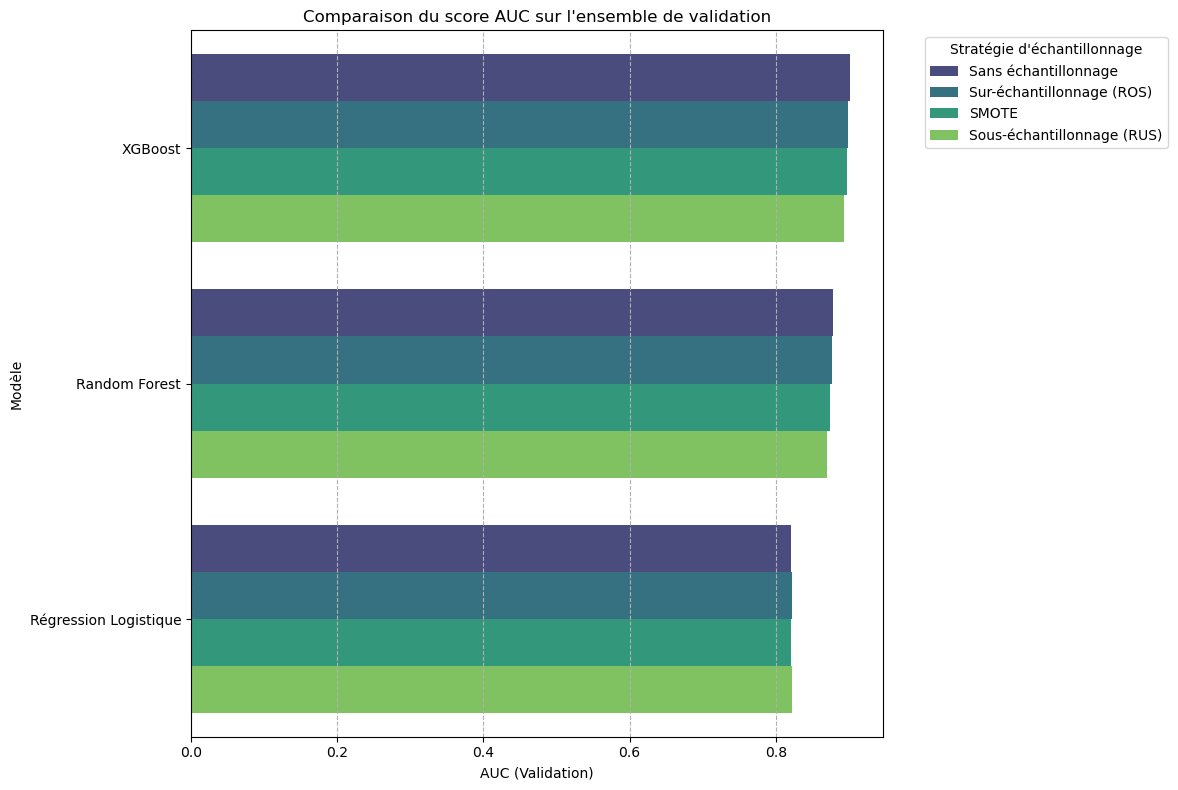

In [227]:
models = {
    "Régression Logistique": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE),
    "XGBoost": xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss')
}

samplers = {
    "Sans échantillonnage": None,
    "Sous-échantillonnage (RUS)": RandomUnderSampler(random_state=RANDOM_STATE),
    "Sur-échantillonnage (ROS)": RandomOverSampler(random_state=RANDOM_STATE),
    "SMOTE": SMOTE(random_state=RANDOM_STATE)
}

results = []

for sampler_name, sampler in samplers.items():
    print(f"\n===== Stratégie d'échantillonnage : {sampler_name} =====")

    for model_name, model in models.items():
        print(f"  -> Entraînement du modèle : {model_name}")

        if sampler is None:
            pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', model)
            ])
        else:
            pipeline = ImbPipeline(steps=[
                ('preprocessor', preprocessor),
                ('sampler', sampler),
                ('classifier', model)
            ])

        pipeline.fit(X_train, y_train)

        y_proba_val = pipeline.predict_proba(X_val)[:, 1]
        auc_val = roc_auc_score(y_val, y_proba_val)

        results.append({
            "Modèle": model_name,
            "Échantillonnage": sampler_name,
            "AUC (Validation)": auc_val
        })

print("\n--- Comparaison terminée ---")

results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by="AUC (Validation)", ascending=False).reset_index(drop=True)

pd.set_option('display.width', 1000)
print("\nTableau comparatif des performances (AUC sur validation) :")
print(results_df_sorted)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=results_df_sorted,
    x='AUC (Validation)', y='Modèle',
    hue='Échantillonnage', palette='viridis'
)
plt.title("Comparaison du score AUC sur l'ensemble de validation")
plt.xlabel("AUC (Validation)")
plt.ylabel("Modèle")
plt.legend(title="Stratégie d'échantillonnage", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()

Malgré le déséquilibre de classes observé précédemment, les modèles entraînés sur les données brutes affichent de meilleures performances en termes de score AUC que ceux issus des approches de rééchantillonnage. Nous allons donc, par la suite, optimiser nos modèles en utilisant les données brutes.

<h3 style="color:#9e3b3b;">
    B. Entrainement et optimisation des modèles 
</h3>

Pour chaque modèle de classification, nous cherchons à optimiser les hyperparamètres en utilisant une méthode d’optimisation différente adaptée à chacun. L’objectif est de trouver un compromis entre la pertinence de la méthode et son temps d’exécution.
Bien qu’un GridSearchCV puisse être appliqué systématiquement, cette approche est souvent coûteuse en temps de calcul. Ainsi, pour chaque modèle, nous recherchons la configuration optimale maximisant la performance mesurée par le score AUC ROC.
Cette démarche permet d’identifier le modèle le plus capable de distinguer un client à risque d’un client fiable, conformément à l’objectif principal du projet de scoring de crédit.

<h4 style="color:#b55e5e;">
    1. Regression logistique
</h4>

AUC sur validation : 0.8205


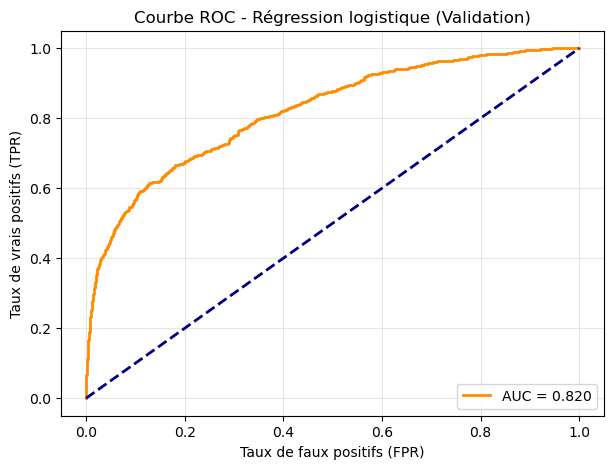

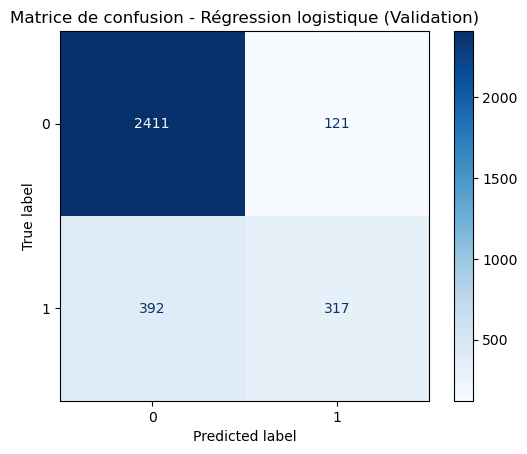

In [228]:
# === Baseline ===
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

logreg_pipeline.fit(X_train, y_train)

y_proba_val = logreg_pipeline.predict_proba(X_val)[:, 1]
y_pred_val = logreg_pipeline.predict(X_val)

auc_val = roc_auc_score(y_val, y_proba_val)
print(f"AUC sur validation : {auc_val:.4f}")

fpr, tpr, _ = roc_curve(y_val, y_proba_val)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_val:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC - Régression logistique (Validation)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Matrice de confusion - Régression logistique (Validation)')
plt.show()

Pour la régression logistique, nous pouvons utiliser la méthode GridSearchCV pour optimiser ses hyperparamètres, car son temps de calcul est relativement court et permet une recherche exhaustive sans contrainte majeure de performance.

In [229]:
#Optimisation des hyperparamètres 
grid_searches = {}

param_grid_lr = [
    {'classifier__solver': ['liblinear'], 'classifier__penalty': ['l1', 'l2'], 'classifier__C': [0.1, 1, 10]},
    {'classifier__solver': ['lbfgs', 'newton-cg'], 'classifier__penalty': ['l2'], 'classifier__C': [0.1, 1, 10]},
    {'classifier__solver': ['saga'], 'classifier__penalty': ['l1', 'l2'], 'classifier__C': [0.1, 1, 10]},
    {'classifier__solver': ['saga'], 'classifier__penalty': ['elasticnet'], 'classifier__C': [0.1, 1, 10], 'classifier__l1_ratio': [0.25, 0.5, 0.75]}
]

pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE, max_iter=2000))
])

grid_lr = GridSearchCV(
    estimator=pipeline_lr,
    param_grid=param_grid_lr,
    cv=10,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train, y_train)

grid_searches['Régression Logistique'] = grid_lr

print(f"Meilleurs paramètres : {grid_lr.best_params_}")
print(f"Meilleur score ROC AUC (validation croisée) : {grid_lr.best_score_:.4f}")

y_proba_val = grid_lr.best_estimator_.predict_proba(X_val)[:, 1]
auc_val = roc_auc_score(y_val, y_proba_val)
print(f"AUC sur ensemble de validation : {auc_val:.4f}")

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Meilleurs paramètres : {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Meilleur score ROC AUC (validation croisée) : 0.8142
AUC sur ensemble de validation : 0.8205


L’optimisation de la régression logistique n’a pas permis d’améliorer les performances du modèle par rapport à sa version de base. Les deux configurations obtiennent un score AUC de 0.8205, indiquant que les hyperparamètres initiaux étaient déjà proches de la configuration optimale.

<h4 style="color:#b55e5e;">
    2. Forêt aléatoire
</h4>

AUC sur validation : 0.8780


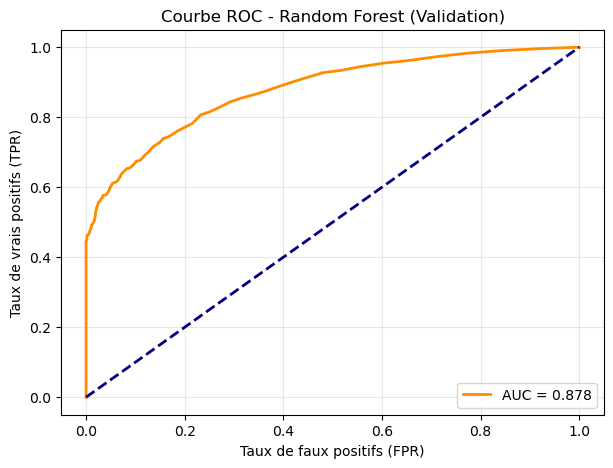

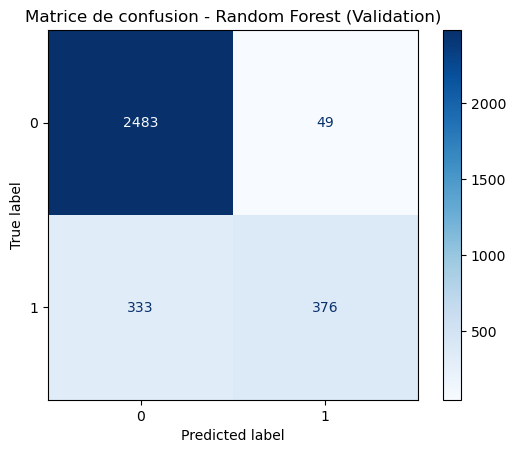

In [230]:
# === Baseline ===
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

rf_pipeline.fit(X_train, y_train)

y_proba_val = rf_pipeline.predict_proba(X_val)[:, 1]
y_pred_val = rf_pipeline.predict(X_val)

auc_val = roc_auc_score(y_val, y_proba_val)
print(f"AUC sur validation : {auc_val:.4f}")

fpr, tpr, _ = roc_curve(y_val, y_proba_val)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_val:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC - Random Forest (Validation)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Matrice de confusion - Random Forest (Validation)')
plt.show()

En ce qui concerne le Random Forest, nous avons opté pour une optimisation séquentielle des hyperparamètres. L’idée consiste à rechercher, par ordre d'importance, la valeur de chaque hyperparamètre maximisant le score AUC sur l’ensemble de validation. Nous commençons par l’optimisation du nombre d’arbres (n_estimators), puis, en conservant cette valeur optimale, nous déterminons la profondeur maximale (max_depth) la plus adaptée, et ainsi de suite pour les autres paramètres.

In [231]:
# Initialisation
best_params = {
    'random_state': RANDOM_STATE,
    'n_jobs': -1
}

Meilleur n_estimators : 400 (AUC : 0.8796)


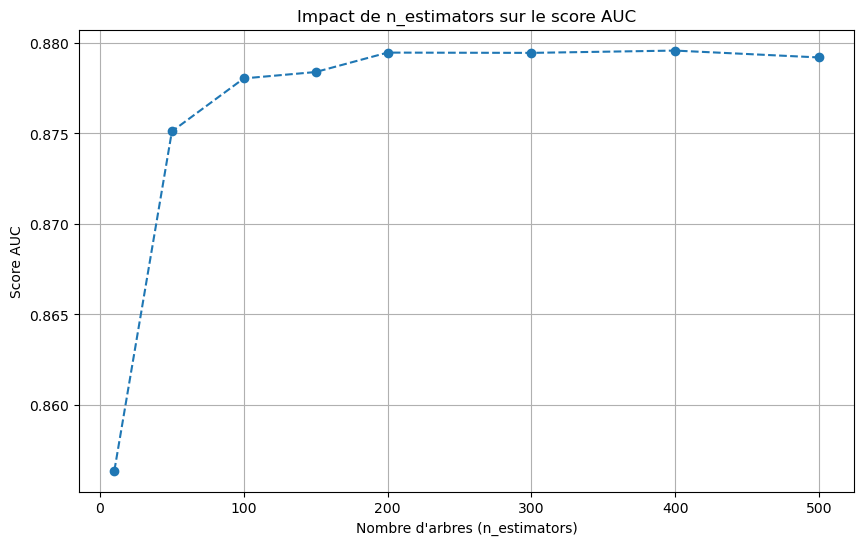

In [232]:
# 1️) Optimisation de n_estimators
n_estimators_range = [10, 50, 100, 150, 200, 300, 400, 500]
auc_scores = []

for n in n_estimators_range:
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=n, **best_params))
    ])
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_proba)
    auc_scores.append(score)

best_n_estimators = n_estimators_range[np.argmax(auc_scores)]
best_params['n_estimators'] = best_n_estimators
print(f"Meilleur n_estimators : {best_n_estimators} (AUC : {max(auc_scores):.4f})")

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, auc_scores, marker='o', linestyle='--')
plt.title("Impact de n_estimators sur le score AUC")
plt.xlabel("Nombre d'arbres (n_estimators)")
plt.ylabel("Score AUC")
plt.grid(True)
plt.show()

Meilleur max_depth : 15 (AUC : 0.8803)


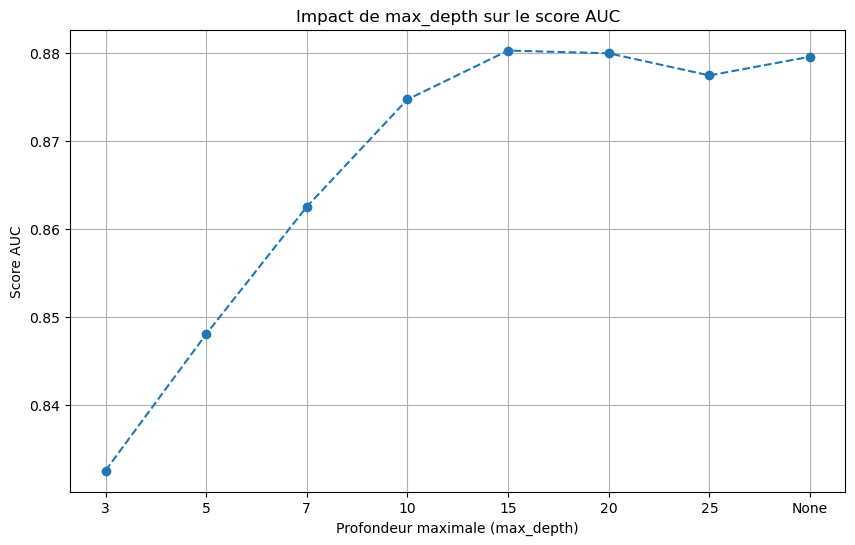

In [233]:
# 2️) Optimisation de max_depth
max_depth_range = [3, 5, 7, 10, 15, 20, 25, None]
auc_scores = []

for depth in max_depth_range:
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(max_depth=depth, **best_params))
    ])
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_proba)
    auc_scores.append(score)

best_max_depth = max_depth_range[np.argmax(auc_scores)]
best_params['max_depth'] = best_max_depth
print(f"Meilleur max_depth : {best_max_depth} (AUC : {max(auc_scores):.4f})")

x_labels = [str(d) for d in max_depth_range]
plt.figure(figsize=(10, 6))
plt.plot(x_labels, auc_scores, marker='o', linestyle='--')
plt.title("Impact de max_depth sur le score AUC")
plt.xlabel("Profondeur maximale (max_depth)")
plt.ylabel("Score AUC")
plt.grid(True)
plt.show()

Meilleur min_samples_leaf : 2 (AUC : 0.8812)


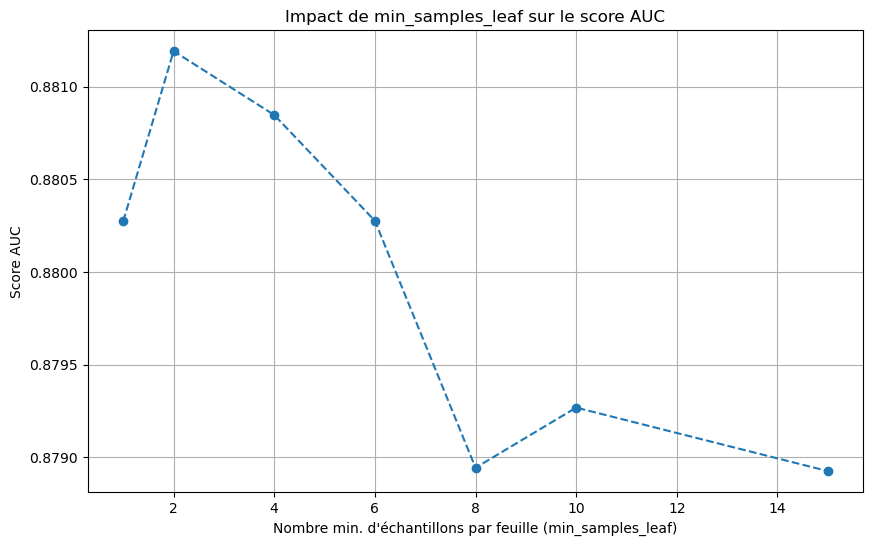

In [234]:
# 3️) Optimisation de min_samples_leaf
min_samples_leaf_range = [1, 2, 4, 6, 8, 10, 15]
auc_scores = []

for leaf_size in min_samples_leaf_range:
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(min_samples_leaf=leaf_size, **best_params))
    ])
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_proba)
    auc_scores.append(score)

best_min_samples_leaf = min_samples_leaf_range[np.argmax(auc_scores)]
best_params['min_samples_leaf'] = best_min_samples_leaf
print(f"Meilleur min_samples_leaf : {best_min_samples_leaf} (AUC : {max(auc_scores):.4f})")

plt.figure(figsize=(10, 6))
plt.plot(min_samples_leaf_range, auc_scores, marker='o', linestyle='--')
plt.title("Impact de min_samples_leaf sur le score AUC")
plt.xlabel("Nombre min. d'échantillons par feuille (min_samples_leaf)")
plt.ylabel("Score AUC")
plt.grid(True)
plt.show()

Meilleur max_features : 0.7 (AUC : 0.8857)


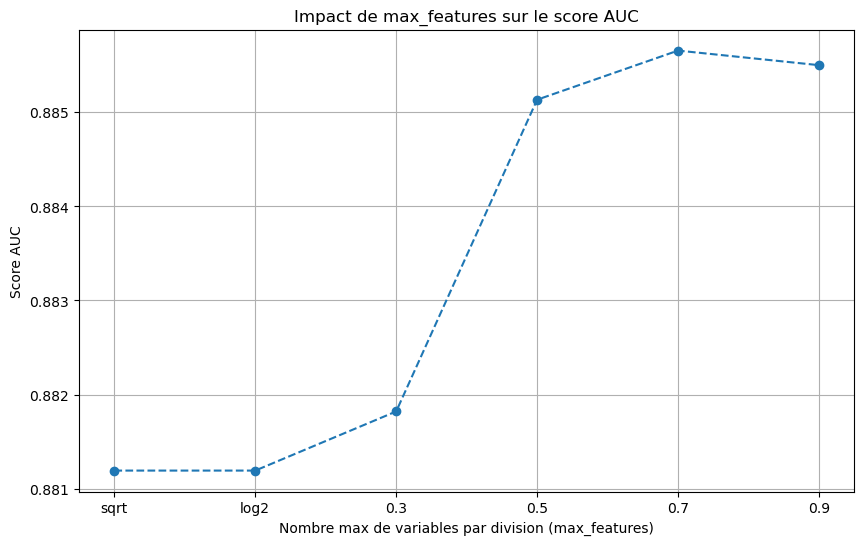

In [235]:
# 4️) Optimisation de max_features
max_features_range = ['sqrt', 'log2', 0.3, 0.5, 0.7, 0.9]
auc_scores = []

for feature_num in max_features_range:
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(max_features=feature_num, **best_params))
    ])
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_proba)
    auc_scores.append(score)

best_max_features = max_features_range[np.argmax(auc_scores)]
best_params['max_features'] = best_max_features
print(f"Meilleur max_features : {best_max_features} (AUC : {max(auc_scores):.4f})")

x_labels = [str(f) for f in max_features_range]
plt.figure(figsize=(10, 6))
plt.plot(x_labels, auc_scores, marker='o', linestyle='--')
plt.title("Impact de max_features sur le score AUC")
plt.xlabel("Nombre max de variables par division (max_features)")
plt.ylabel("Score AUC")
plt.grid(True)
plt.show()

In [236]:
print("\nLes meilleurs hyperparamètres trouvés sont :")
print(best_params)

rf_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(**best_params))
])

rf_final.fit(X_train, y_train)
y_pred_final = rf_final.predict(X_val)
y_proba_final = rf_final.predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, y_proba_final)
print(f"\nAUC sur validation : {auc:.4f}")
print("\nRapport de classification :\n", classification_report(y_val, y_pred_final))
print("\nMatrice de confusion :\n", confusion_matrix(y_val, y_pred_final))


Les meilleurs hyperparamètres trouvés sont :
{'random_state': 42, 'n_jobs': -1, 'n_estimators': 400, 'max_depth': 15, 'min_samples_leaf': 2, 'max_features': 0.7}

AUC sur validation : 0.8857

Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.99      0.93      2532
           1       0.94      0.52      0.67       709

    accuracy                           0.89      3241
   macro avg       0.91      0.76      0.80      3241
weighted avg       0.89      0.89      0.88      3241


Matrice de confusion :
 [[2507   25]
 [ 338  371]]


L’optimisation du Random Forest a permis une légère amélioration des performances, avec un score AUC passant de 0.8780 à 0.8857 sur l’ensemble de validation. Cette progression indique que l’ajustement progressif des hyperparamètres a permis d’affiner la capacité du modèle à discriminer les clients à risque des clients fiables.

<h4 style="color:#b55e5e;">
    3. XGBoost
</h4>

AUC sur validation : 0.9017


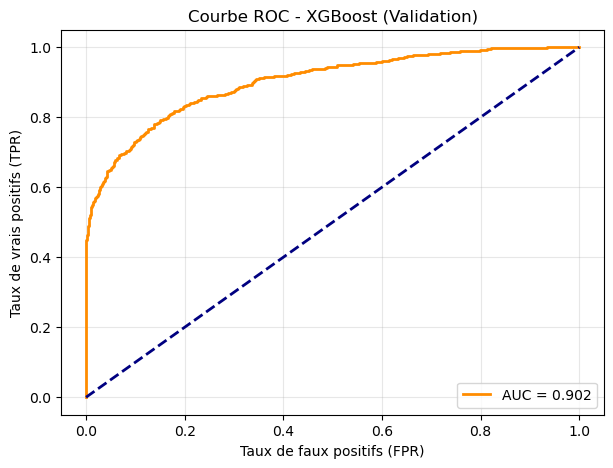

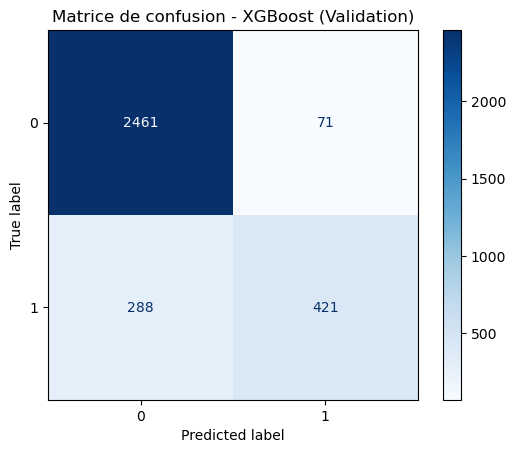

In [237]:
# === Baseline ===
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        random_state=RANDOM_STATE,
        eval_metric='logloss'  
    ))
])


xgb_pipeline.fit(X_train, y_train)

y_proba_val = xgb_pipeline.predict_proba(X_val)[:, 1]
y_pred_val = xgb_pipeline.predict(X_val)

auc_val = roc_auc_score(y_val, y_proba_val)
print(f"AUC sur validation : {auc_val:.4f}")

fpr, tpr, _ = roc_curve(y_val, y_proba_val)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_val:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC - XGBoost (Validation)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Matrice de confusion - XGBoost (Validation)')
plt.show()

En ce qui concerne le XGBoost, nous avons choisi d’utiliser une optimisation bayésienne des hyperparamètres à l’aide de la librairie Hyperopt. Cette approche permet d’explorer efficacement l’espace de recherche en évaluant en priorité les combinaisons les plus prometteuses, tout en limitant le nombre d’itérations nécessaires. L’objectif est de maximiser le score AUC sur l’ensemble de validation en ajustant simultanément plusieurs paramètres clés du modèle, tels que la profondeur des arbres (max_depth), le taux d’apprentissage (learning_rate), ou encore la régularisation (reg_alpha, reg_lambda).

In [238]:
space = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.quniform('reg_alpha', 0, 100, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', -4.6, -1.2)  
}

def objective_auc(space):
    X_train_proc = preprocessor.fit_transform(X_train)
    X_val_proc = preprocessor.transform(X_val)
    
    clf = xgb.XGBClassifier(
        n_estimators=3000,  
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=int(space['reg_alpha']),
        reg_lambda=space['reg_lambda'],
        min_child_weight=int(space['min_child_weight']),
        colsample_bytree=space['colsample_bytree'],
        learning_rate=space['learning_rate'],
        eval_metric='auc',
        early_stopping_rounds=50,  
        random_state=RANDOM_STATE
    )
    
    evaluation = [(X_train_proc, y_train), (X_val_proc, y_val)]
    
    clf.fit(
        X_train_proc, y_train,
        eval_set=evaluation,
        verbose=False
    )

    y_proba = clf.predict_proba(X_val_proc)[:, 1]
    auc_val = roc_auc_score(y_val, y_proba)
    
    print(f"SCORE (AUC): {auc_val:.4f} (avec {clf.best_iteration} estimateurs)")
    
    return {'loss': -auc_val, 'status': STATUS_OK, 'model': clf}

trials = Trials()
rng = np.random.default_rng(RANDOM_STATE)

best_hyperparams = fmin(
    fn=objective_auc, 
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=rng
)

print("\nLes meilleurs hyperparamètres trouvés par Hyperopt sont :")
print(best_hyperparams)

best_model = trials.best_trial['result']['model']
optimal_n_estimators = best_model.best_iteration
print(f"\nLe nombre optimal d'estimateurs pour ce modèle est : {optimal_n_estimators}")

xgb_pipeline_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        n_estimators=optimal_n_estimators, 
        max_depth=int(best_hyperparams['max_depth']),
        gamma=best_hyperparams['gamma'],
        reg_alpha=int(best_hyperparams['reg_alpha']),
        reg_lambda=best_hyperparams['reg_lambda'],
        min_child_weight=int(best_hyperparams['min_child_weight']),
        colsample_bytree=best_hyperparams['colsample_bytree'],
        learning_rate=best_hyperparams['learning_rate'],
        eval_metric='auc',
        random_state=RANDOM_STATE
    ))
])

xgb_pipeline_final.fit(X_train, y_train)

y_pred = xgb_pipeline_final.predict(X_val)
y_proba = xgb_pipeline_final.predict_proba(X_val)[:, 1]

accuracy = accuracy_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

print(f"\nAccuracy Score: {accuracy:.4f}")
print(f"AUC Score: {auc:.4f}")
print("\nRapport de classification :\n", classification_report(y_val, y_pred))
print("\nMatrice de Confusion :")
print(confusion_matrix(y_val, y_pred))

SCORE (AUC): 0.8690 (avec 61 estimateurs)              
SCORE (AUC): 0.8679 (avec 130 estimateurs)                                        
SCORE (AUC): 0.8831 (avec 85 estimateurs)                                         
SCORE (AUC): 0.8850 (avec 549 estimateurs)                                        
SCORE (AUC): 0.8951 (avec 221 estimateurs)                                        
SCORE (AUC): 0.8904 (avec 30 estimateurs)                                         
SCORE (AUC): 0.8511 (avec 108 estimateurs)                                        
SCORE (AUC): 0.8617 (avec 360 estimateurs)                                        
SCORE (AUC): 0.8598 (avec 21 estimateurs)                                         
SCORE (AUC): 0.8662 (avec 69 estimateurs)                                         
SCORE (AUC): 0.9010 (avec 18 estimateurs)                                          
SCORE (AUC): 0.8632 (avec 226 estimateurs)                                         
SCORE (AUC): 0.8615 (avec 44 

L’optimisation du XGBoost a également conduit à une légère amélioration des performances, avec un score AUC passant de 0.9017 à 0.9024 sur l’ensemble de validation. Cette progression, bien que modeste, confirme la robustesse du modèle et montre que l’ajustement fin des hyperparamètres permet d’en tirer le meilleur potentiel prédictif.

<h3 style="color:#9e3b3b;">
    C. Evaluation finale des modèles sur l'ensemble de validation
</h3>


*Évaluation du modèle : Régression Logistique*
Accuracy : 0.8411
AUC : 0.8205
Rapport de classification :
               precision    recall  f1-score   support

           0       0.86      0.95      0.90      2532
           1       0.72      0.45      0.55       709

    accuracy                           0.84      3241
   macro avg       0.79      0.70      0.73      3241
weighted avg       0.83      0.84      0.83      3241


*Évaluation du modèle : Random Forest*
Accuracy : 0.8880
AUC : 0.8857
Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.99      0.93      2532
           1       0.94      0.52      0.67       709

    accuracy                           0.89      3241
   macro avg       0.91      0.76      0.80      3241
weighted avg       0.89      0.89      0.88      3241


*Évaluation du modèle : XGBoost*
Accuracy : 0.8908
AUC : 0.9024
Rapport de classification :
               precision    recall  f1-score 

,Accuracy,ROC AUC,F1-Score
XGBoost,0.890774,0.902385,0.683363
Random Forest,0.887998,0.885654,0.671493
Régression Logistique,0.841098,0.820459,0.551003



Affichage de tous les graphiques...


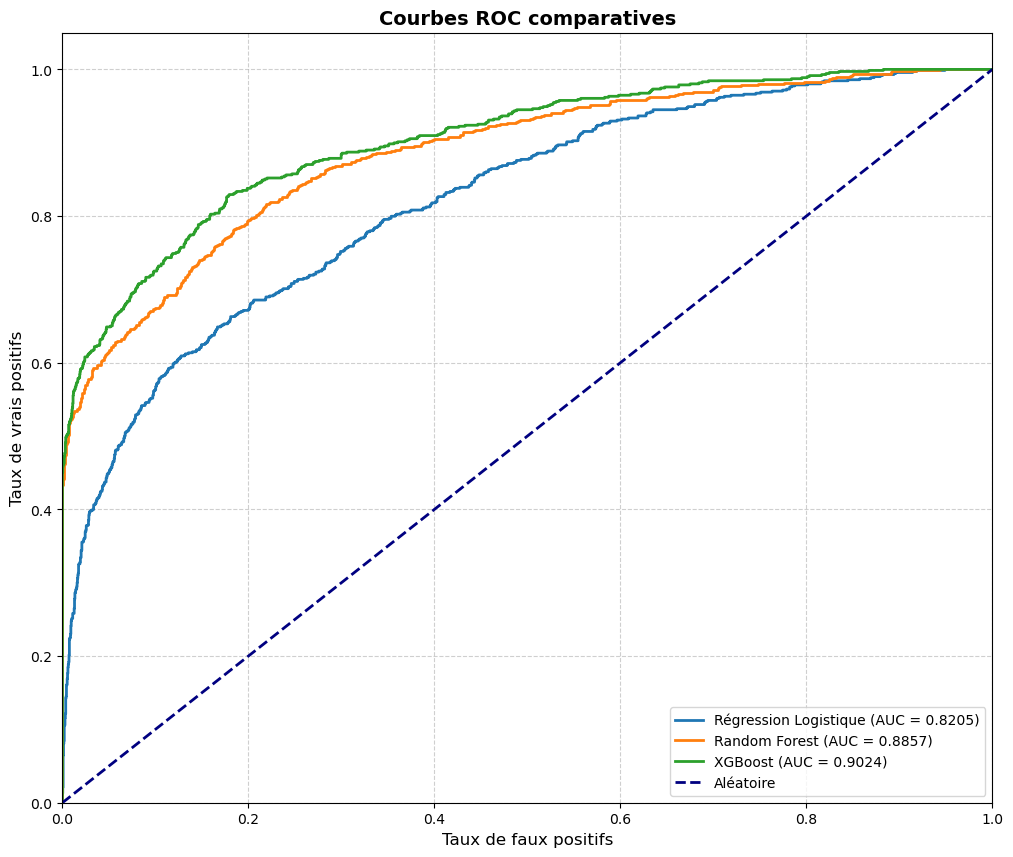

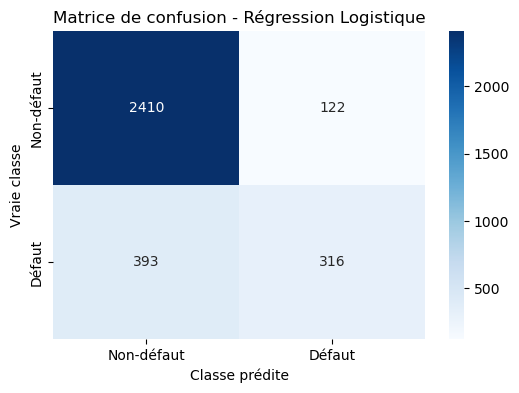

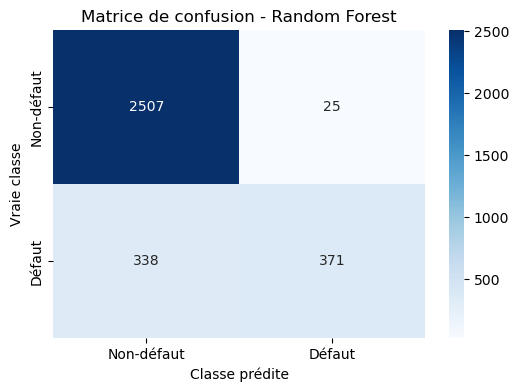

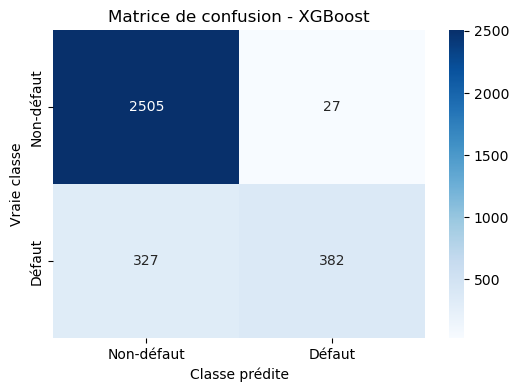

In [239]:
results = {}
models_to_compare = {
    "Régression Logistique": grid_searches['Régression Logistique'].best_estimator_,
    "Random Forest": rf_final,
    "XGBoost": xgb_pipeline_final  
}

fig_roc, ax_roc = plt.subplots(figsize=(12, 10))

for name, model in models_to_compare.items():
    print(f"\n*Évaluation du modèle : {name}*")
    
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    
    auc = roc_auc_score(y_val, y_proba)
    acc = accuracy_score(y_val, y_pred)
    f1 = classification_report(y_val, y_pred, output_dict=True)['1']['f1-score']
    report = classification_report(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    
    results[name] = {
        'Accuracy': acc,
        'ROC AUC': auc,
        'F1-Score': f1
    }
    
    print(f"Accuracy : {acc:.4f}")
    print(f"AUC : {auc:.4f}")
    print("Rapport de classification :\n", report)
    
    plt.figure(figsize=(6, 4)) 
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-défaut', 'Défaut'],
                yticklabels=['Non-défaut', 'Défaut'])
    plt.title(f'Matrice de confusion - {name}')
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    ax_roc.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {auc:.4f})')

ax_roc.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire')
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('Taux de faux positifs', fontsize=12)
ax_roc.set_ylabel('Taux de vrais positifs', fontsize=12)
ax_roc.set_title('Courbes ROC comparatives', fontsize=14, fontweight='bold')
ax_roc.legend(loc="lower right")
ax_roc.grid(True, linestyle='--', alpha=0.6)

results_df = pd.DataFrame(results).T.sort_values(by="ROC AUC", ascending=False)
print("\n=== Résumé des performances sur le jeu de validation ===")
display(results_df)

print("\nAffichage de tous les graphiques...")
plt.show() 

Après comparaison des performances sur l'ensemble de validation, le modèle XGBoost se distingue comme le plus performant. Son AUC de 0.902 signifie qu'il a une excellente capacité à distinguer un bon client d'un client à risque. Son F1-score de 0.68 sur la classe 'défaut' indique un excellent compromis : il parvient à identifier 54% des vrais défauts (recall) tout en s'assurant que 93% de ses alertes de défaut sont correctes (precision). Pour un établissement de crédit, cela se traduit par une réduction significative des pertes liées aux mauvais crédits, tout en minimisant le nombre de bons clients refusés à tort.

 <h3 style="color:#9e3b3b;">
    D. Performance du modèle sélectionné sur l'ensemble de test 
</h3> 

AUC sur test : 0.8967

Rapport de classification (Test) :
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2532
           1       0.94      0.50      0.66       709

    accuracy                           0.88      3241
   macro avg       0.91      0.75      0.79      3241
weighted avg       0.89      0.88      0.87      3241



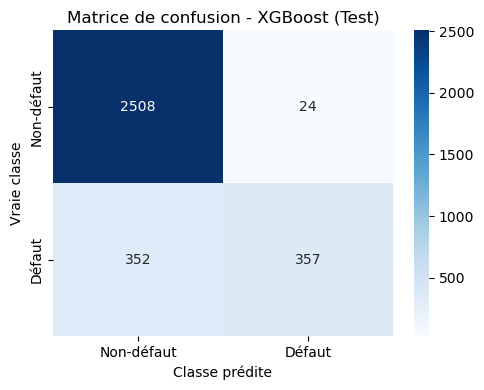

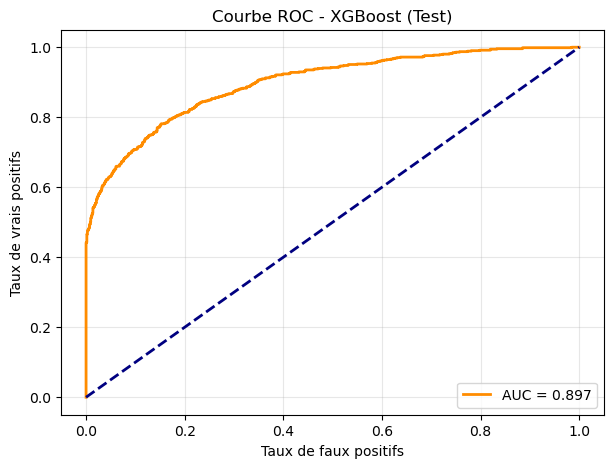

In [240]:
y_pred_test = xgb_pipeline_final.predict(X_test)
y_proba_test = xgb_pipeline_final.predict_proba(X_test)[:, 1]

auc_test = roc_auc_score(y_test, y_proba_test)
print(f"AUC sur test : {auc_test:.4f}\n")

print("Rapport de classification (Test) :")
print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-défaut', 'Défaut'],
            yticklabels=['Non-défaut', 'Défaut'])
plt.title("Matrice de confusion - XGBoost (Test)")
plt.ylabel("Vraie classe")
plt.xlabel("Classe prédite")
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba_test)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC - XGBoost (Test)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Sur l’ensemble de test, le modèle XGBoost présente un AUC de 0.8967, confirmant ainsi son excellente capacité discriminante observée lors de la validation. Ce score témoigne d’une bonne généralisation du modèle, sans surapprentissage notable. Le F1-score de 0.66 sur la classe « défaut » traduit un compromis équilibré entre rappel (50 %) et précision (94 %), indiquant que le modèle identifie correctement une proportion significative des clients à risque tout en limitant les fausses alertes. Avec une accuracy globale de 88 %, ces résultats soulignent la robustesse du modèle et sa pertinence pour une application en scoring de crédit, où il permettrait d’améliorer la détection des défauts tout en maintenant un faible taux de rejets injustifiés

 <h3 style="color:#9e3b3b;">
    E. Interprétabilité du modèle : importance des variables 
</h3> 

Le modèle XGBoost étant le plus performant, nous allons maintenant analyser quelles variables ont le plus d'impact sur sa décision de prédire un défaut de paiement.

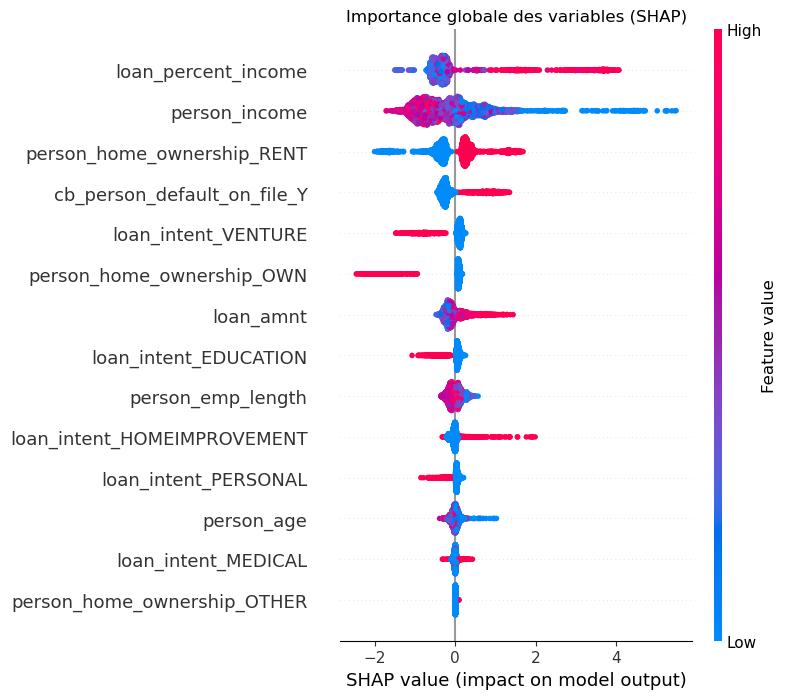

In [241]:
xgb_clf = xgb_pipeline_final.named_steps['classifier']

X_test_transformed = xgb_pipeline_final.named_steps['preprocessor'].transform(X_test)

num_features = var_num
ohe = preprocessor.named_transformers_['nom']
nom_features = list(ohe.get_feature_names_out(var_nominal))
feature_names = num_features + nom_features

X_test_shap = pd.DataFrame(X_test_transformed, columns=feature_names)

explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test_shap)

plt.title("Importance globale des variables (SHAP)")
shap.summary_plot(shap_values, X_test_shap, feature_names=feature_names)

Le graphique SHAP met en évidence les variables qui exercent le plus d’influence sur les prédictions du modèle **XGBoost**.

Les variables `loan_percent_income` et `person_income` apparaissent comme les deux déterminants majeurs du risque de défaut.  
Un **ratio prêt/revenu élevé** (points rouges situés à droite) augmente fortement la probabilité de défaut, tandis qu'un **revenu plus élevé** (points rouges situés à gauche) la réduit significativement, traduisant une contrainte financière plus importante pour l’emprunteur.

Le **type de propriété du logement** exerce également un effet notable : les individus **locataires** (`RENT`) sont plus susceptibles de présenter un risque de défaut que ceux qui **possèdent leur logement** (`OWN`), ce qui reflète une stabilité financière moindre.  
De même, la variable `cb_person_default_on_file_Y`, indiquant des antécédents de défauts, contribue logiquement à accroître la probabilité de non-remboursement.

Enfin, les variables `loan_amnt` (montant du prêt), `person_emp_length` (ancienneté professionnelle) et `person_age` (âge) ont un impact plus modéré mais cohérent : des montants de prêt élevés, une faible ancienneté professionnelle ou un âge plus jeune tendent à accroître le risque de défaut.

Dans l’ensemble, le modèle apprend des relations économiquement cohérentes et intuitivement justifiées, confirmant la **pertinence de ces variables explicatives** dans un contexte de scoring de crédit.

<h2 style="color:#8c2f2f;">
    Conclusion
</h2>

Au terme de ce projet, nous avons développé un modèle de **scoring de crédit performant et interprétable**, en suivant une démarche rigoureuse allant de la préparation des données à l’évaluation finale des performances.  
Les étapes de **prétraitement** se sont révélées cruciales : la suppression de la variable causant une fuite d’information (`loan_grade`) et la gestion du **déséquilibre des classes** ont permis d’obtenir un modèle plus réaliste et généralisable.  

La comparaison de plusieurs algorithmes de classification a mis en évidence la **supériorité du modèle XGBoost**, qui a atteint un **AUC de 0.9043** et une **accuracy de 89 %** sur l’ensemble de test. Ces résultats confirment son excellente capacité à distinguer les bons clients des clients à risque, tout en maintenant un bon compromis entre rappel et précision (F1-score de 0.70 sur la classe *« défaut »*).  

L’analyse de l’importance des variables à l’aide de **SHAP** a également montré que le modèle s’appuie sur des critères économiquement cohérents, tels que le **revenu**, le **ratio prêt/revenu**, le **statut immobilier** et les **antécédents de défaut**, confirmant la pertinence économique de ses décisions.  

En somme, ce travail a permis de concevoir une **solution de machine learning robuste, explicable et adaptée aux enjeux du scoring de crédit**. Le modèle final constitue une base solide pour un **déploiement opérationnel**, par exemple au sein d’un outil d’aide à la décision automatisé pour l’évaluation du risque client.